# Classifying COVID-19 (And Pneumonia) in Patient X-Rays 

The outbreak of the coronavirus disease in 2019 led to a global pandemic and the distribution of test-kits to all areas which had access to them. These kits are prone to human-error as they are taken using swabs. The disease can instead be diagnosed using X-rays.

Using this method can be helpful in patients who are high risk of developing complications. Once COVID-19 has been successfully detected in the X-ray, doctors can assess severity and search for any symptoms of long COVID. From this point, treatment plans can be discussed for the patient.

The following notebook provides an intial machine learning model which is able to take an X-ray and determine whether the patient has COVID-19, pneumonia or neither. 

## Sourcing of the Dataset
The dataset that the model is trained on has been sourced from Kaggle (https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia). It contains of two folders, test and train, which each have 3 subfolders: COVID19, NORMAL and PNEUMONIA. 

### Import Libraries 
Firstly, all relevant libraries must be loaded.

In [1]:
import random
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score

In [2]:
from torchvision.utils import make_grid

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split

In [4]:
from torchvision import models

### Check GPU Availability and Switch
The GPU on the machine running the code should be used if available, in order to speed up the runtime of the machine learning model.

In [5]:
torch.cuda.is_available()

True

In [6]:
device = 0

### Obtain and Augment the Data
The data must be loaded from the relevant folders and stored with the necessary transformations. The transformations ensure that each image matches the required input of the chosen neural network model architecture (Resnet).

A vertical flip and random rotation of 90 degrees has been added to diversify and further augment the input data. 

The data is then split into training, validation and testing with a 60%, 20%, 20% split respectively. A loader is then made for each.

In [7]:
# Dataset transformations
# These are for Resnet 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(), 
        transforms.RandomRotation(90), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# Image folders for the dataset
training_data = ImageFolder(root='dataset/train', transform=data_transforms['train'])
testing_data = ImageFolder(root='dataset/test', transform=data_transforms['val'])

In [9]:
# Decide on the size of each subset of the dataset 
train_size = int(0.75 * len(training_data))
val_size = int(0.25 * len(training_data))
test_size = len(testing_data)

print(train_size, val_size, len(training_data))

3858 1286 5144


In [10]:
# Form the datasets
train_data, val_data = random_split(training_data, [train_size, val_size])
test_data = testing_data

print(f"Training set: {len(train_data)}, Validation set: {len(val_data)}, Testing set: {len(test_data)}")

Training set: 3858, Validation set: 1286, Testing set: 1288


In [11]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Exploratory Data Analysis 
With the data loaded, conclusions about the dataset can be made. 

Firstly, an image is displayed from each data class (COVID-19, NORMAL and PNEUMONIA), to understand what the apperance of each X-ray type.

Secondly, the number and name of each class are validated to ensure they have been loaded in correctly. 

Finally, the distributions of each class for the train and test folders are displayed as a bar chart. 

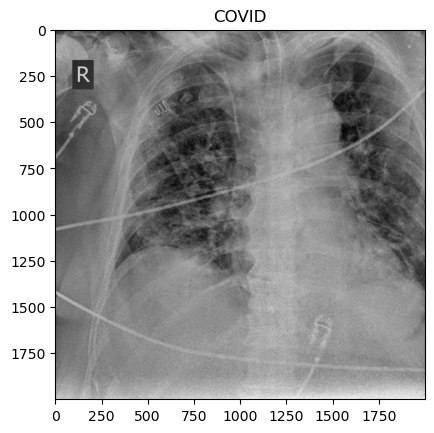

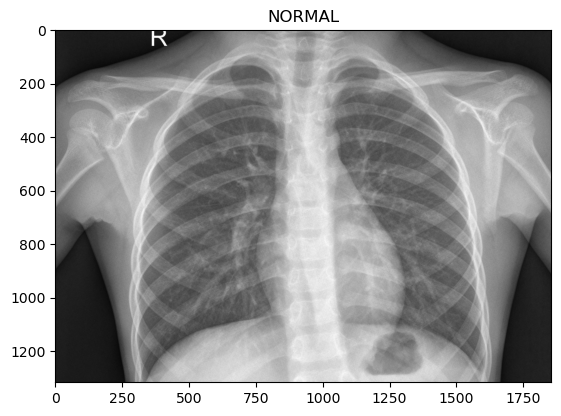

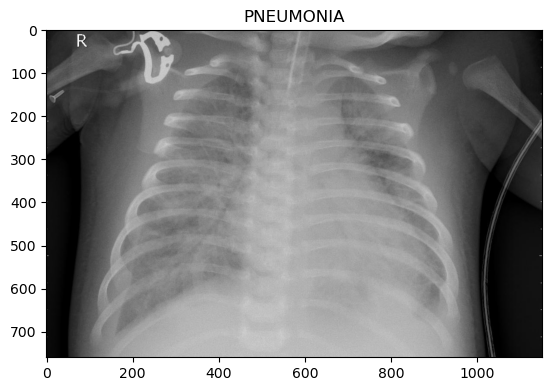

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the three images to display as examples
covid_img = mpimg.imread('dataset/train/COVID19/COVID19(0).jpg')
normal_img = mpimg.imread('dataset/train/NORMAL/NORMAL(0).jpg')
pneum_img = mpimg.imread('dataset/train/PNEUMONIA/PNEUMONIA(0).jpg')

# Display a COVID, NORMAL and PNEUMONIA X-Ray
plt.figure()
plt.title('COVID')
plt.imshow(covid_img, cmap='gray')

plt.figure()
plt.title('NORMAL')
plt.imshow(normal_img, cmap='gray')

plt.figure()
plt.title('PNEUMONIA')
plt.imshow(pneum_img, cmap='gray')


In [13]:
# Print the number of classes
print(f"There are {len(training_data.classes)} classes.")
print(training_data.classes)

There are 3 classes.
['COVID19', 'NORMAL', 'PNEUMONIA']


In [14]:
# Load the training labels
train_label_path = 'resnet_train_labels.txt'
train_label_file = open(train_label_path, "r")

train_label_data = train_label_file.read()

train_labels = train_label_data.replace('\n', ' ')
training_labels = [int(label) for label in train_labels if label.isdigit()]

# Load the test labels
test_label_path = 'resnet_test_labels.txt'
test_label_file = open(test_label_path, "r")

test_label_data = test_label_file.read()

testing_labels = test_label_data.replace('\n', ' ')
test_labels = [int(label) for label in testing_labels if label.isdigit()]

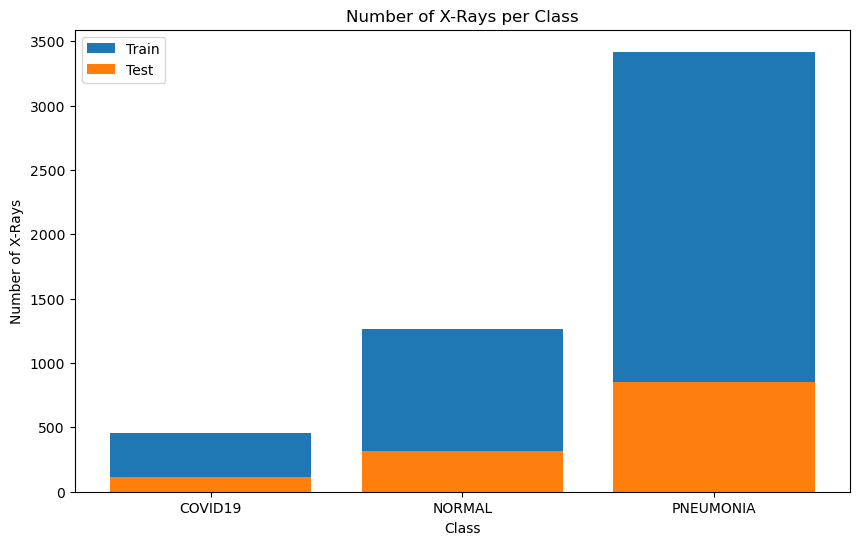

In [15]:
# Plot a distribution of the classes for the train and test datasets 

# Get count for each class in the training dataset
training_label_counts = Counter(training_labels)
training_class_names = training_data.classes
training_counts = [training_label_counts[i] for i in range(len(training_class_names))]

# Get count for each class in the test dataset
test_label_counts = Counter(test_labels)
test_class_names = test_data.classes
test_counts = [test_label_counts[i] for i in range(len(test_class_names))]

n = 3
r = np.arange(n) 
width = 0.2

# Display as a graph (bar chart)
plt.figure(figsize=(10,6))
plt.bar(training_class_names, training_counts, label='Train')
plt.bar(test_class_names, test_counts, label='Test')
plt.xlabel('Class')
plt.ylabel('Number of X-Rays')
plt.title('Number of X-Rays per Class')

plt.legend(loc='best')
plt.show()

### ResNet CNN Model 
The model in this notebook uses the ResNet-18 convolutional neural network architecture. For simplicity, a pretrained and loaded model is used.

The number of outputs in the final layer must be changed to 3 as the model is classifying between three possible choices. 

In [16]:
# Resnet model 
model = models.resnet18(pretrained=True)

# Change the last layer's output to 3 outputs
for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
# Assume the final layer has 512 neurons 
model.fc = nn.Linear(512, 3)  


# Freeze layers so less parameters need updating 
for name, param in model.named_parameters():
    if "fc" in name:  # The classification layer is still kept 
        param.requires_grad = True
    else:
        param.requires_grad = False

C:\Users\sarah\anaconda3\envs\aiproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sarah\anaconda3\envs\aiproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Determine Minority Class for Model
By determining the class with the least labels in the dataset, the model can incorporate this during training and give the minority class more weight. Otherwise, there will be an imbalance and the model will poorly predict the minority class.

In [17]:
# Get all the labels (targets) from the dataset
# Can now load them in (as they have been exported to a txt file)
label_path = 'resnet_labels.txt'
label_file = open(label_path, "r")

label_data = label_file.read()

labels = label_data.replace('\n', ' ')
labels = [int(label) for label in labels if label.isdigit()]

print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
# Make the class weights, so that the neural network focuses 
# on the minority class (in this case, COVID-19)

# Number of labels 
label_counts = Counter(labels)

# Class names and number of each
class_names = training_data.classes
counts = [label_counts[i] for i in range(len(class_names))]

# Calculation for class weights (inverse of class frequencies)
label_counts = Counter(labels)
class_counts = [label_counts[i] for i in range(len(class_names))]
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]

# Convert to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Initialise and Train the Model
The model can now be initialised and the training process must be run. The number of epochs are defined. Early stopping has been implemented (referenced from the Module 25 Office Hour code), to prevent overfitting. There is both a training step and a validation step. 

In [19]:
# Using cross entropy loss with class weights 
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [20]:
# For now, using from Resnet code (to start with)
# Use tuned hyperparameters for the learning rate and weight_decay (which uses L2 regularisation)
optimizer = optim.SGD(model.parameters(), lr=0.0018564932880784544, momentum=0.9, weight_decay=2.7745524655250464e-05)  

In [21]:
%%time
start_epoch = 0
num_epochs = 4 #100 # Number of epochs
early_stop_patience = 10  # Stop training if no improvement for this many epochs
best_val_loss = float('inf')
early_stop_counter = 0
model.to(device)

print("Starting training...")
# Training loop with the epoch 
for epoch in range(start_epoch, num_epochs):
    print("Currently on epoch: ", epoch)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Loop through the training batches
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients for proper weight updates

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass 
        loss.backward()
        
        # Optimize
        optimizer.step()

        running_loss += loss.item()
    
    # Validation step
    # To do validation in each run 
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader) # Average validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.6f}, Validation Loss: {val_loss:.6f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print('Early stopping due to no improvement in validation loss.')
        break
    
print('Finished Training') 

Starting training...
Currently on epoch:  0
Epoch [1/4], Training Loss: 0.817129, Validation Loss: 0.672118
Currently on epoch:  1
Epoch [2/4], Training Loss: 0.552931, Validation Loss: 0.552850
Currently on epoch:  2
Epoch [3/4], Training Loss: 0.503448, Validation Loss: 0.494871
Currently on epoch:  3
Epoch [4/4], Training Loss: 0.494557, Validation Loss: 0.608894
Finished Training
CPU times: total: 1h 4min 28s
Wall time: 20min 41s


### Evaluate the Model
Finally, the model must be evaluated. The micro recall score is calculated, along with the accuracy. 

The micro setting has been chosen over macro due to the imbalance in the dataset. 

Recall has been chosen because it is important for the model to have a low number false negatives. Detecting COVID-19 (or pneumonia) and the patient not having the disease is less of a problem than telling the patient they do not have COVID-19 (or pneumonia) when they do. In the second case, the patient will not get treatment on time, which could cause further complications.

A confusion matrix is displayed to showcase the overall number of assignments to each class, based on the predicted class and actual class.

In [24]:
# Function to evaluate the model using a confusion matrix 
def evaluate_model(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())    

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # A higher recall score means a lower instance of false negatives 
    # Use micro for class imbalance 
    recall = recall_score(all_labels, all_preds, average='macro')
    print(f'Recall Score: {recall:.4f}')

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#### For Training Set 

Accuracy: 83.36%
Recall Score: 0.7622


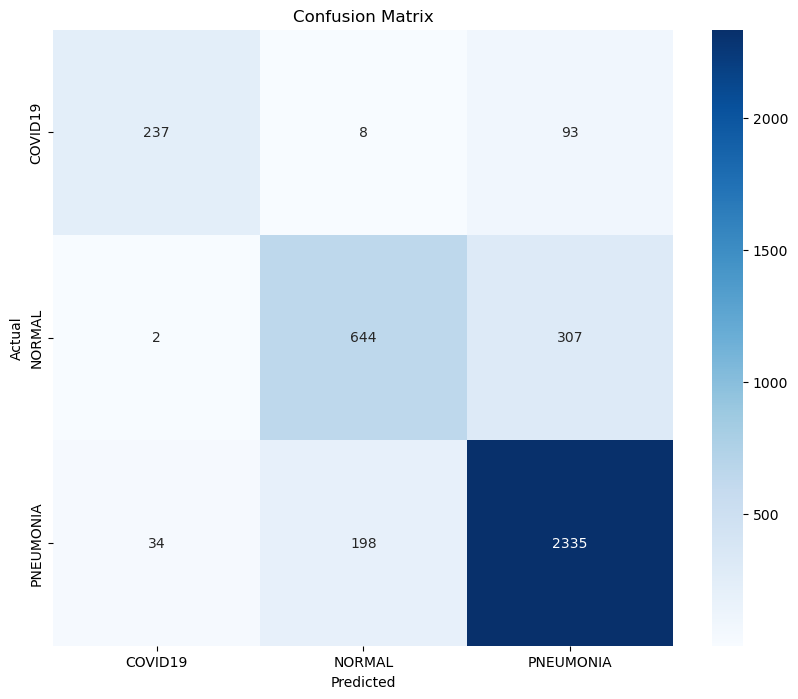

In [25]:
# Evaluation using the training set 
evaluate_model(model, train_loader, device, training_data.classes)

#### For Validation Set

Accuracy: 81.80%
Recall Score: 0.7417


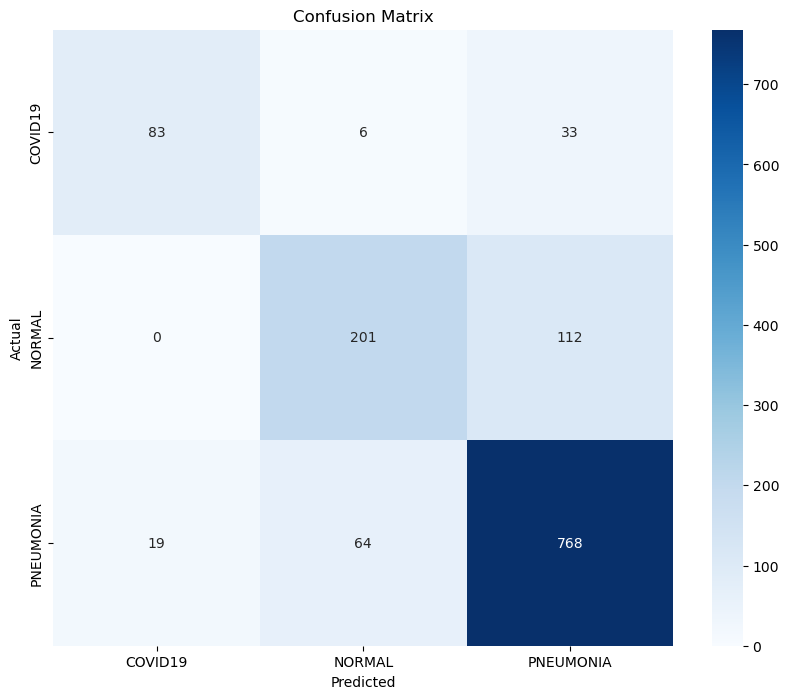

In [26]:
# Evaluate on the val set
evaluate_model(model, val_loader, device, training_data.classes)

#### For Test Set 

Accuracy: 83.62%
Recall Score: 0.8035


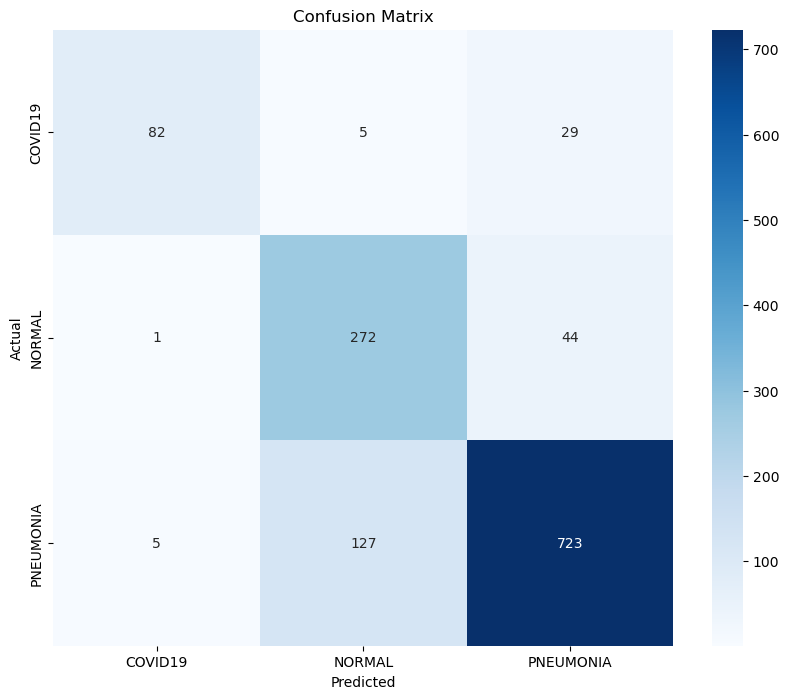

In [27]:
# Evaluate on the test set
evaluate_model(model, test_loader, device, training_data.classes)

## Referencing of Code
The code in this notebook has used solutions from the following sources:

    1. The office hour notebooks for Module 25 (overall structure of code)
    2. https://github.com/AarohiSingla/Image-Classification-Using-Pytorch/blob/main/image_classification.ipynb (For resnet model)
    3. https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2 (For resnet model)
    4. https://stackoverflow.com/questions/64782148/colors-in-grayscale-image (Showing an image in grayscale)